# Speech Emotion Recognition

### https://www.kaggle.com/shivamburnwal/speech-emotion-recognition/notebook

### Importing libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Ravdess Dataframe

In [63]:
# Paths for data.
Ravdess = "data/"

#Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [65]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(15)

,Emotions,Path
0,neutral,data/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,data/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,data/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,data/Actor_01/03-01-01-01-02-02-01.wav
4,calm,data/Actor_01/03-01-02-01-01-01-01.wav
5,calm,data/Actor_01/03-01-02-01-01-02-01.wav
6,calm,data/Actor_01/03-01-02-01-02-01-01.wav
7,calm,data/Actor_01/03-01-02-01-02-02-01.wav
8,calm,data/Actor_01/03-01-02-02-01-01-01.wav
9,calm,data/Actor_01/03-01-02-02-01-02-01.wav


In [67]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,data/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,data/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,data/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,data/Actor_01/03-01-01-01-02-02-01.wav
4,calm,data/Actor_01/03-01-02-01-01-01-01.wav


### Data Visualisation and Exploration

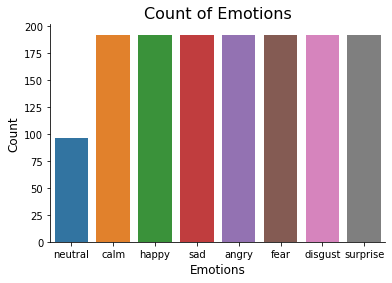

In [68]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Plotting waveplots and spectograms for audio signals

### Waveplots illustrates the loudness of the audio at a given time
### Spectograms are  a visual representation of the spectrum of frequencies of sound or other signals as they vary with time, it’s a representation of frequencies changing with respect to time for given audio/music signals.

In [69]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

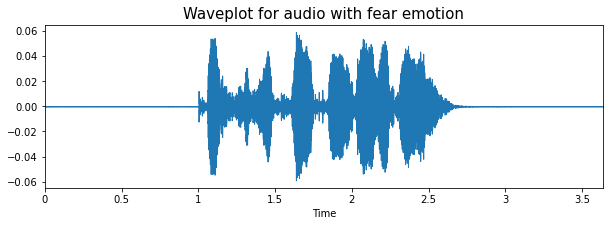

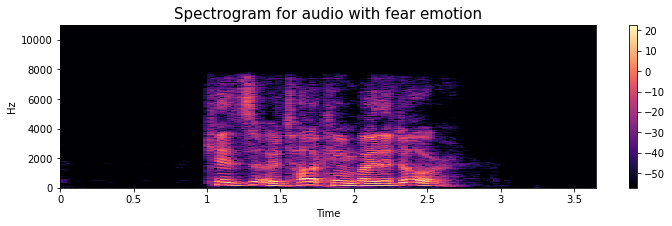

In [70]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

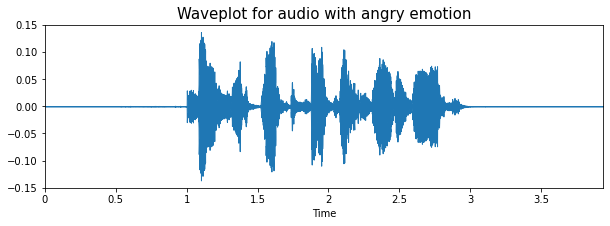

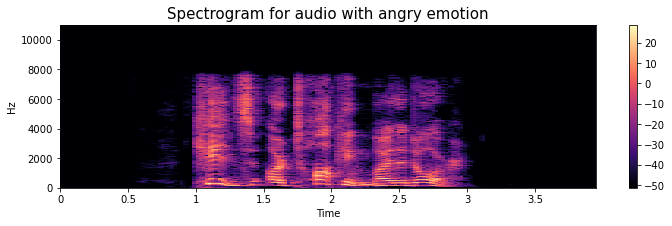

In [71]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

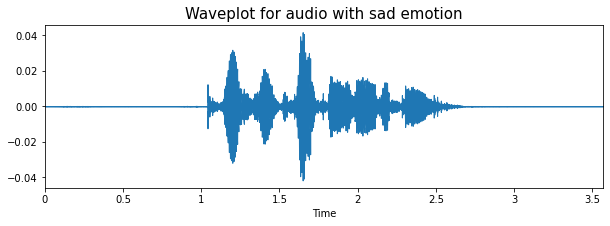

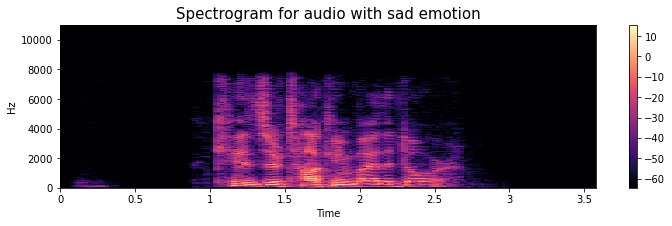

In [72]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

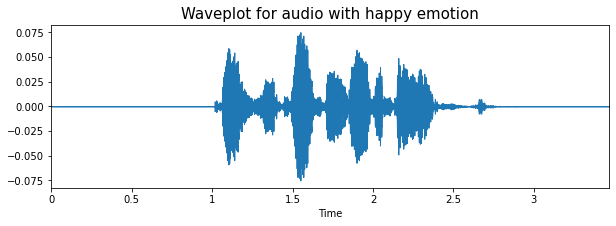

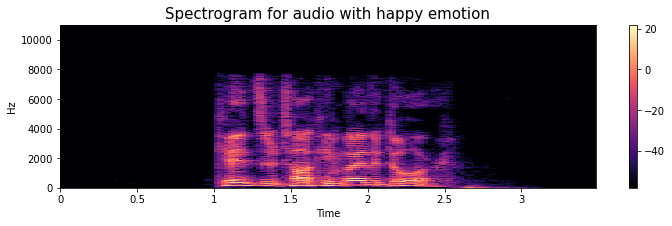

In [73]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data Augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set

### To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
### The objective is to make our model invariant to those perturbations and enhace its ability to generalize
### In order to this to work adding the perturbations must conserve the same label as the original training sample
### In images data augmention can be performed by shifting the image, zooming, rotating ...
### Checking which augmentation techniques works better for our dataset

In [74]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

### Simple audio

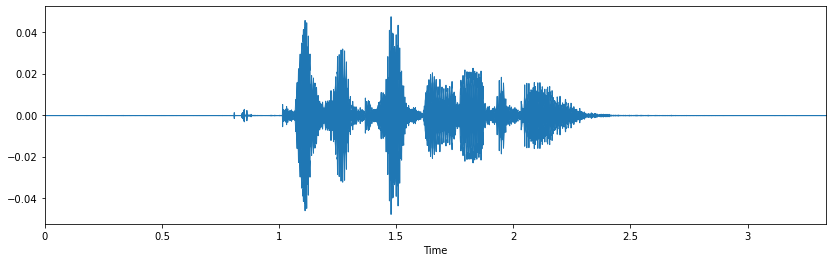

In [75]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### Noise Injection is a very good augmentation technique because of which we can assure the training model is not overfitted

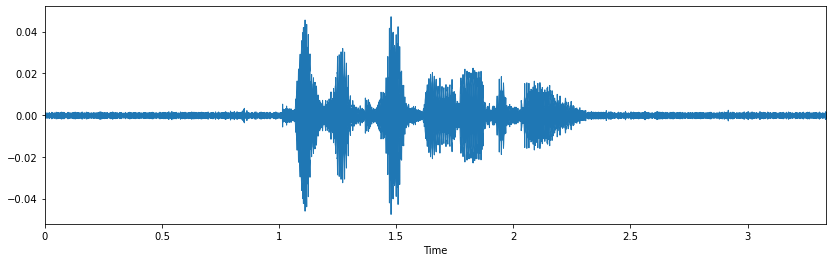

In [76]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

###  Stretching

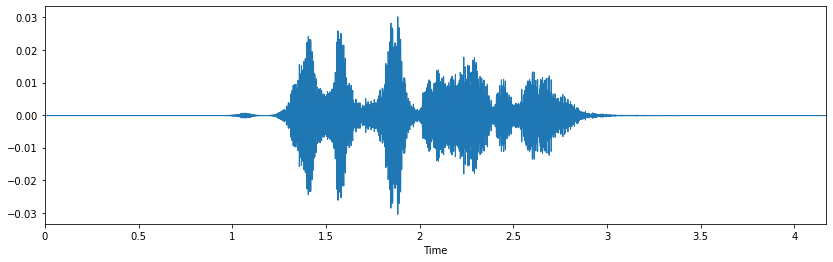

In [77]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

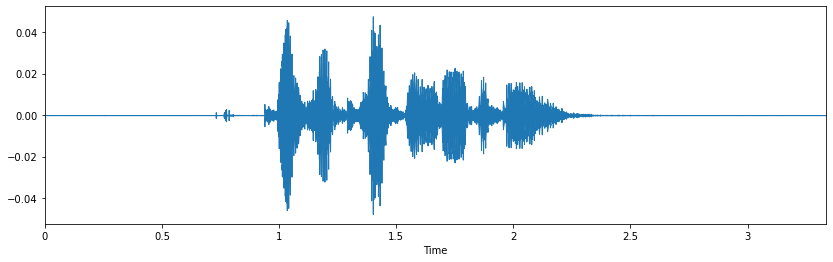

In [78]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitching

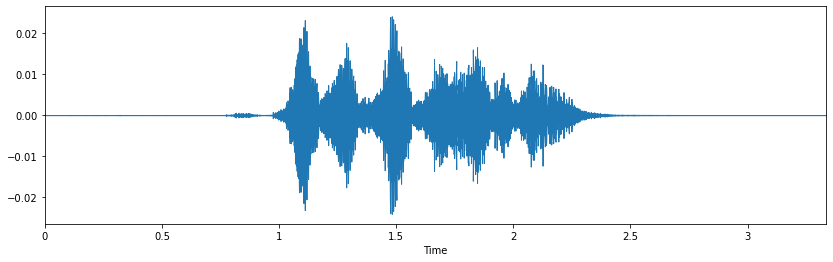

In [79]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Feature Extraction

### Extracting 5 features:

### Zero Crossing Rate
### Chroma_stft
### MFCC
### RMS(root mean square) value
### MelSpectogram to train our model.

In [80]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

### Normalizing and splitting the data for training and testing

In [81]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [82]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [83]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237707,0.659504,0.688300,0.660306,0.668153,0.691578,0.679806,0.700728,0.743931,0.777429,...,1.971535e-16,1.694119e-16,1.561859e-16,1.566727e-16,1.521193e-16,1.325442e-16,1.309995e-16,1.341276e-16,1.188672e-16,neutral
1,0.313996,0.768974,0.822075,0.808738,0.801229,0.803669,0.719625,0.665168,0.709500,0.750890,...,4.460327e-05,4.405087e-05,4.698836e-05,4.544296e-05,4.389523e-05,4.542646e-05,4.573825e-05,4.380583e-05,4.543636e-05,neutral
2,0.166967,0.578606,0.608995,0.669059,0.597341,0.606837,0.673560,0.681284,0.704720,0.715759,...,8.504842e-13,7.684326e-13,5.920987e-13,5.803375e-13,6.579538e-13,5.743235e-13,4.853721e-13,5.919732e-13,5.719862e-13,neutral
3,0.207284,0.649996,0.689978,0.661347,0.645627,0.683498,0.684929,0.679601,0.732510,0.756296,...,9.362395e-17,1.017879e-16,8.988049e-17,9.321180e-17,9.068552e-17,9.977286e-17,8.490875e-17,8.585167e-17,9.594946e-17,neutral
4,0.319910,0.775286,0.820589,0.796569,0.776003,0.777753,0.737935,0.668378,0.706037,0.744107,...,6.973870e-05,7.275610e-05,7.209981e-05,7.368876e-05,7.092135e-05,7.064018e-05,7.014664e-05,7.075476e-05,7.115369e-05,neutral


In [84]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [85]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [86]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [87]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [88]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

### Modelling

In [89]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [90]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 22s 405ms/step - loss: 1.9955 - accuracy: 0.1994 - val_loss: 1.9191 - val_accuracy: 0.2593
Epoch 2/50
51/51 [==============================] - 22s 440ms/step - loss: 1.9278 - accuracy: 0.2392 - val_loss: 1.8219 - val_accuracy: 0.2824
Epoch 3/50
51/51 [==============================] - 22s 437ms/step - loss: 1.8898 - accuracy: 0.2586 - val_loss: 1.7733 - val_accuracy: 0.3389
Epoch 4/50
51/51 [==============================] - 21s 411ms/step - loss: 1.8285 - accuracy: 0.2781 - val_loss: 1.7021 - val_accuracy: 0.3370
Epoch 5/50
51/51 [==============================] - 21s 414ms/step - loss: 1.7699 - accuracy: 0.3009 - val_loss: 1.6496 - val_accuracy: 0.3852
Epoch 6/50
51/51 [==============================] - 21s 403ms/step - loss: 1.7244 - accuracy: 0.3191 - val_loss: 1.5817 - val_accuracy: 0.4037
Epoch 7/50
51/51 [==============================] - 22s 433ms/step - loss: 1.6860 - accuracy: 0.3423 - val_loss: 1.5692 - val_accuracy: 0.3981

34/34 [==============================] - 2s 50ms/step - loss: 1.3569 - accuracy: 0.6231
Accuracy of our model on test data :  62.31481432914734 %


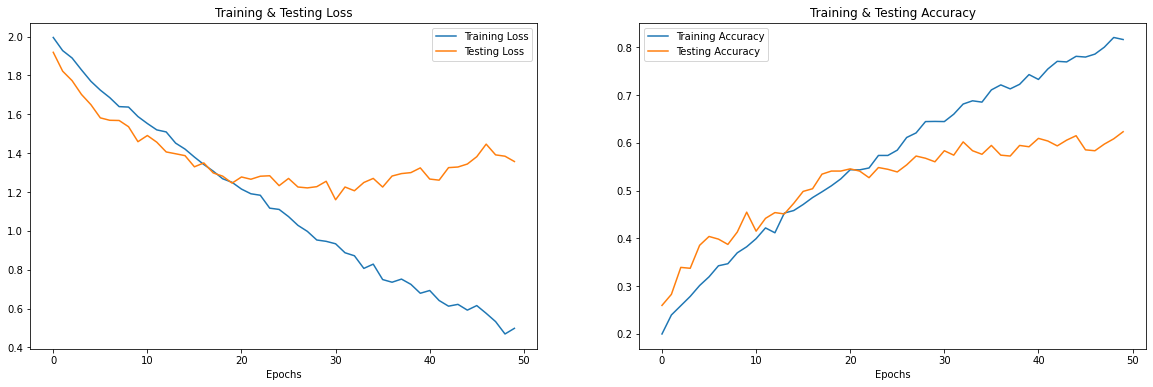

In [91]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [92]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [96]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,fear,fear
1,surprise,angry
2,fear,fear
3,calm,calm
4,angry,angry
5,surprise,surprise
6,sad,fear
7,fear,happy
8,fear,fear
9,calm,sad


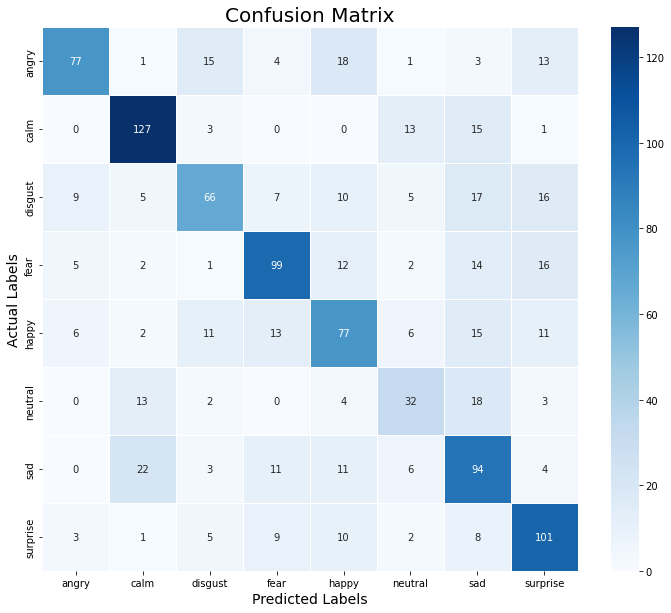

In [94]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.77      0.58      0.66       132
        calm       0.73      0.80      0.77       159
     disgust       0.62      0.49      0.55       135
        fear       0.69      0.66      0.67       151
       happy       0.54      0.55      0.54       141
     neutral       0.48      0.44      0.46        72
         sad       0.51      0.62      0.56       151
    surprise       0.61      0.73      0.66       139

    accuracy                           0.62      1080
   macro avg       0.62      0.61      0.61      1080
weighted avg       0.63      0.62      0.62      1080



### Above we can see that the model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
### Achieved 62% accuracy on our test data, we can improve it more by applying more augmentation techniques and using other feature extraction methods.